In [121]:
import numpy as np
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from controller_Nash import PCEController
from scipy.linalg import solve_continuous_lyapunov as solve_lyapunov
from numpy.linalg import norm, inv
from scipy.integrate import solve_ivp

In [122]:
# システム行列の例
def A_delta(delta):
    return np.array([
    [-2 + delta, 1.0],
    [0.0, -2.0 + delta]
])

def B1_delta(delta):
    return np.array([
    [1.0],
    [1.0]
])

def B2_delta(delta):
    return np.array([
    [1.0],
    [1.0]
])

Q1 = np.array([[0.1, 0.2], [0.2, 0.1]])
Q2 = np.array([[0.1, 0.2], [0.2, 0.1]])
R11 = np.array([[1.]])
R12 = np.array([[1.]])
R21 = np.array([[1.]])
R22 = np.array([[1.]])
p_order = 4

In [123]:
# インスタンス生成（関数の参照を渡す！）
controller = PCEController(A_delta, B1_delta, B2_delta, Q1, Q2, R11, R12, R21, R22, p_order)

# gPC行列の計算
Agpc = controller.Agpc
B1gpc = controller.B1gpc
B2gpc = controller.B2gpc
Q1= controller.Q1_bar
Q2= controller.Q2_bar
R11= controller.R11_bar
R12= controller.R12_bar
R21= controller.R21_bar
R22= controller.R22_bar
p_terms = controller.p_terms
n = controller.n
# print("Agpc:")
# print(Agpc)
# print("B1gpc:")
# print(B1gpc)
# print("B2gpc:")
# print(B2gpc)

In [124]:
"""
ニュートン法で連続時間型リカッチ方程式を解く
A, B, Q, R: numpy配列
tol: 収束許容誤差
max_iter: 最大反復回数
"""
P1, P2 = controller.solve_riccati_newton(Agpc, B1gpc, B2gpc, Q1, Q2, R11, R12, R21, R22)
# print("解 P1:")
# print(P1)
# print("解 P2:")
# print(P2)

収束しました。反復回数: 5


In [125]:
# 3. フィードバックゲイン計算
K1 = inv(R11) @ B1gpc.T @ P1
K2 = inv(R22) @ B2gpc.T @ P2
A_cl = Agpc - B1gpc @ K1 - B2gpc @ K2  # 閉ループ系
eigvals = np.linalg.eigvals(A_cl)
print("A_cl の固有値:", eigvals)

A_cl の固有値: [-2.83694178+0.31000181j -2.83694178-0.31000181j -1.55061614+0.37964872j
 -1.55061614-0.37964872j -1.83032112+0.36459658j -1.83032112-0.36459658j
 -2.52602573+0.32516864j -2.52602573-0.32516864j -2.17225167+0.34449575j
 -2.17225167-0.34449575j]


In [126]:
# 4. シミュレーション
def dynamics(t, x):
    return A_cl @ x

# 初期状態 x(0)
x0 = np.ones([p_terms*n]) # p_terms*nと同じ次元
x0 = 0.00*x0
initial_list = [1.0, 0.1]
for i in range(n):
    x0[i*(p_terms)] = initial_list[i]
t_span = (0, 10)
t_eval = np.linspace(*t_span, 300)

sol = solve_ivp(dynamics, t_span, x0, t_eval=t_eval)

# 5. ノルムの時間変化を計算
x_t = sol.y
x_norms = np.linalg.norm(x_t, axis=0)

In [127]:
# 平均と分散を計算
mean_x1 = sol.y[0]
var_x1  = np.zeros_like(sol.y[0])
for i in range(1, p_terms):
    norm = 2 / (2*i + 1)  # Legendreの内積
    var_x1 += (sol.y[i]**2) * norm
mean_x2 = sol.y[p_terms]
var_x2  = np.zeros_like(sol.y[p_terms])
for i in range(1, p_terms):
    norm = 2 / (2*i + 1)  # Legendreの内積
    var_x2 += (sol.y[i+p_terms]**2) * norm

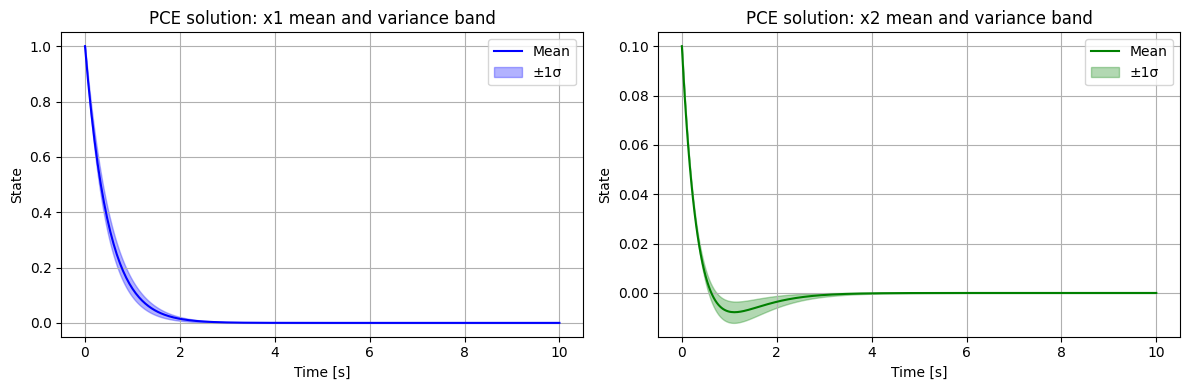

In [128]:
# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- x1 のプロット ---
axes[0].plot(sol.t, mean_x1, label="Mean", color="blue")
axes[0].fill_between(sol.t, mean_x1 - np.sqrt(var_x1), mean_x1 + np.sqrt(var_x1), 
                     alpha=0.3, color="blue", label="±1σ")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("State")
axes[0].grid(True)
axes[0].legend()
axes[0].set_title("PCE solution: x1 mean and variance band")

# --- x2 のプロット ---
axes[1].plot(sol.t, mean_x2, label="Mean", color="green")
axes[1].fill_between(sol.t, mean_x2 - np.sqrt(var_x2), mean_x2 + np.sqrt(var_x2), 
                     alpha=0.3, color="green", label="±1σ")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("State")
axes[1].grid(True)
axes[1].legend()
axes[1].set_title("PCE solution: x2 mean and variance band")

# 全体のレイアウト調整
plt.tight_layout()
plt.show()


In [129]:
'''
# モンテカルロで実装
eigs_mc, mean_mc, var_mc = controller.simulate_mc(1000, initial_list, t_span, t_eval)

# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- x1 のプロット ---
axes[0].plot(t_eval, mean_mc[0], label="MC Mean", color="blue")
axes[0].fill_between(t_eval, mean_mc[0] - np.sqrt(var_mc[0]), mean_mc[0] + np.sqrt(var_mc[0]), 
                     alpha=0.3, color="blue", label="±1σ")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("State")
axes[0].grid(True)
axes[0].legend()
axes[0].set_title("MC solution: x1 mean and variance band")

# --- x2 のプロット ---
axes[1].plot(t_eval, mean_mc[1], label="Mean", color="green")
axes[1].fill_between(t_eval, mean_mc[1] - np.sqrt(var_mc[1]), mean_mc[1] + np.sqrt(var_mc[1]), 
                     alpha=0.3, color="green", label="±1σ")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("State")
axes[1].grid(True)
axes[1].legend()
axes[1].set_title("MC solution: x2 mean and variance band")

# 全体のレイアウト調整
plt.tight_layout()
plt.show()
'''

'\n# モンテカルロで実装\neigs_mc, mean_mc, var_mc = controller.simulate_mc(1000, initial_list, t_span, t_eval)\n\n# プロットの準備\nfig, axes = plt.subplots(1, 2, figsize=(12, 4))\n\n# --- x1 のプロット ---\naxes[0].plot(t_eval, mean_mc[0], label="MC Mean", color="blue")\naxes[0].fill_between(t_eval, mean_mc[0] - np.sqrt(var_mc[0]), mean_mc[0] + np.sqrt(var_mc[0]), \n                     alpha=0.3, color="blue", label="±1σ")\naxes[0].set_xlabel("Time [s]")\naxes[0].set_ylabel("State")\naxes[0].grid(True)\naxes[0].legend()\naxes[0].set_title("MC solution: x1 mean and variance band")\n\n# --- x2 のプロット ---\naxes[1].plot(t_eval, mean_mc[1], label="Mean", color="green")\naxes[1].fill_between(t_eval, mean_mc[1] - np.sqrt(var_mc[1]), mean_mc[1] + np.sqrt(var_mc[1]), \n                     alpha=0.3, color="green", label="±1σ")\naxes[1].set_xlabel("Time [s]")\naxes[1].set_ylabel("State")\naxes[1].grid(True)\naxes[1].legend()\naxes[1].set_title("MC solution: x2 mean and variance band")\n\n# 全体のレイアウト調整\nplt.tight_la

In [130]:
# # 6. グラフ描画
# plt.rcParams['font.family'] = 'Meiryo'
# plt.figure(figsize=(8, 4))
# plt.plot(sol.t, x_norms)
# plt.xlabel('Time [s]')
# plt.ylabel('||x(t)||')
# plt.title('状態ベクトル x(t) のノルムの時間変化')
# plt.grid(True)
# plt.tight_layout()
# plt.show()